# SDSS Active Learning

In [220]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.core.display import HTML
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn import metrics
%matplotlib inline
plt.style.use('ggplot')
%run scripts/performance_measures.py
HTML(open("styles/stylesheet.css", "r").read())

## 1. Active Learning Routine

Let us start by writing a general active learning routine which can take as input any classifier and active learning rule.

In [101]:
def active_learning(training_pool, testing_pool, training_oracle, testing_oracle, total_n, initial_n,
                    random_n, active_learning_heuristic, classifier, compute_accuracy, n_classes,
                    committee=None, bag_size=None, verbose=False):
    """ Conduct active learning and return a learning curve.
    
        Parameters
        ----------
        training_pool : array, shape = [n_samples, n_features]
            The feature matrix of all the training examples. Throughout the training phase,
            the active learner will select an oject from this pool to query to oracle.
            
        testing_pool : array, shape = [n_samples, n_features]
            The feature matrix of the test examples, which will be used to assess the accuracy
            rate of the active learner.
            
        training_oracle : array, shape = [n_samples]
            The array of class labels corresponding to the training examples.
            
        testing_oracle : array, shape = [n_samples]
            The array of class labels corresponding to the test examples.
            
        total_n : int
            The total number of samples that the active learner will query.
            
        initial_n : int
            The number of samples that the active learner will randomly select at the beginning
            to get the algorithm started.
            
        random_n : int
            At each iteration, the active learner will pick a random of sample of examples.
            It will then compute a score for each of example and query the one with the
            highest score according to the active learning rule. If random_n is set to 0,
            the entire training pool will be sampled (which can be inefficient with large
            datasets).
            
        active_learning_heuristic : function
            This is the function that implements the active learning rule. Given a set
            of training candidates and the classifier as inputs, the function will
            return index array of candidate(s) with the highest score(s).
            
        classifier : Classifier object
            A classifier object that will be used to train and test the data.
            It should have the same interface as scikit-learn classifiers.
               
        compute_accuracy : function
            Given a trained classifier, a test set, and a test oracle, this function
            will return the accuracy rate.
        
        n_classes : int
            The number of classes.
        
        committee : list of Classifier object
            A list that contains the committee of classifiers used by the query by bagging heuristics.
        
        bag_size : int
            The number of training examples used by each member in the committee.
        
        verbose : boolean
            If set to True, progress is printed to standard output after every 100 iterations.
            
        Returns
        -------
        learning_curve : array
            Every time the active learner queries the oracle, it will re-train the classifier
            and run it on the test data to get an accuracy rate. The learning curve is
            simply the array containing all of these accuracy rates.
    """
    
    n_features = training_pool.shape[1]
    learning_curve = []
    
    # the training examples that haven't been queried
    unlabelled_pool, unlabelled_oracle = training_pool.copy(), training_oracle.copy()
    
    # training examples that have been queried
    X_train = np.empty((0, n_features), float)
    y_train = np.array([])
    
    # select an initial random sample from the pool and train the classifier
    candidate_index = np.random.choice(np.arange(0, len(unlabelled_oracle)), initial_n, replace=False)
    
    # get the feature matrix and labels for our candidates
    X_train_candidates = unlabelled_pool[candidate_index]
    y_train_candidates = unlabelled_oracle[candidate_index]
    
    # add candidate to current training pool
    X_train = np.append(X_train, X_train_candidates, axis=0)
    y_train = np.concatenate((y_train, y_train_candidates))
                                  
    # remove candidate from existing unlabelled pool
    unlabelled_pool = np.delete(unlabelled_pool, candidate_index, axis=0)
    unlabelled_oracle = np.delete(unlabelled_oracle, candidate_index)
    
    # train and test the classifer
    classifier.fit(X_train, y_train)
    accuracy = compute_accuracy(classifier, testing_pool, testing_oracle)
    learning_curve.append(accuracy)

    
    while len(y_train) < total_n:
        
        # select a random sample from the unlabelled pool
        candindate_size = min(random_n, len(unlabelled_oracle))
        candidate_index = np.random.choice(np.arange(0, len(unlabelled_oracle)), candindate_size, replace=False)
        
        # get the feature matrix and labels for our candidates
        X_train_candidates = unlabelled_pool[candidate_index]
        y_train_candidates = unlabelled_oracle[candidate_index]

        # pick the best candidate using an active learning heuristic
        best_index = active_learning_heuristic(
            X_train_candidates, X_train=X_train, y_train=y_train, n_classes=n_classes,
            classifier=classifier, committee=committee, bag_size=bag_size)

        # add candidate to current training pool
        X_train = np.append(X_train, X_train_candidates[best_index], axis=0)
        y_train = np.concatenate((y_train, y_train_candidates[best_index]))

        # remove candidate from existing unlabelled pool
        best_index_in_unlabelled = candidate_index[best_index]
        unlabelled_pool = np.delete(unlabelled_pool, best_index_in_unlabelled, axis=0)
        unlabelled_oracle = np.delete(unlabelled_oracle, best_index_in_unlabelled)

        # train and test the classifer again
        classifier.fit(X_train, y_train)
        accuracy = compute_accuracy(classifier, testing_pool, testing_oracle)
        learning_curve.append(accuracy)
        
        # print progress after every 100 queries
        if verbose and len(y_train) % 100 == 0:
            if len(y_train) % 1000 == 0:
                print(len(y_train), end='')
            else:
                print('.', end='')
    
    return learning_curve

In [3]:
def compute_accuracy(classifier, testing_pool, testing_oracle):
    """ Compute the accuracy of a classifier based on some test set. """
    
    y_pred = classifier.predict(testing_pool)
    confusion_test = metrics.confusion_matrix(testing_oracle, y_pred)
    return balanced_accuracy_expected(confusion_test)

## 2. Active Learning Rules

### 2.1. Random Benchmark

In [41]:
def ac_random(X_training_candidates, **kwargs):
    """ Return a random candidate. """
    
    random_index = np.random.choice(np.arange(0, len(X_training_candidates)), 1, replace=False)
    return random_index

### 2.2. Uncertainty Sampling

In [43]:
def ac_entropy(X_training_candidates, **kwargs):
    """ Return the candidate whose prediction vector displays the greatest Shannon entropy. """
    
    # get the classifier
    classifier = kwargs['classifier']
    
    # predict probabilities
    probs = classifier.predict_proba(X_training_candidates)
    
    # comptue Shannon entropy
    shannon = -np.sum(probs * np.log(probs), axis=1)
    
    # pick the candidate with the greatest Shannon entropy
    greatest_shannon = np.argmax(shannon)
    
    return [greatest_shannon]

In [44]:
def ac_margin(X_training_candidates, **kwargs):
    """ Return the candidate with the smallest margin.
    
        The margin is defined as the difference between the two largest values
        in the prediction vector.
    """
    
    # get the classifier
    classifier = kwargs['classifier']
    
    # predict probabilities
    probs = classifier.predict_proba(X_training_candidates)
    
    # sort the probabilities from smallest to largest
    probs = np.sort(probs, axis=1)
    
    # compute the margin (difference between two largest values)
    margins = np.abs(probs[:,-1] - probs[:,-2])
    
    # pick the candidate with the smallest margin
    smallest_margin = np.argmin(margins)
    
    return [smallest_margin]

### 2.3. Query by Committee/Bagging

In [162]:
def ac_qbb_margin(X_training_candidates, **kwargs):
    """ Return the candidate with the smallest average margin.
    
        We first use bagging to train k classifiers. The margin is then defined as
        the average difference between the two largest values in the prediction vector.
    """
    
    # extract parameters
    committee = kwargs['committee']
    bag_size = kwargs['bag_size']
    X_train = kwargs['X_train']
    y_train = kwargs['y_train']
    n_classes = kwargs['n_classes']
    
    # intialise probability matrix
    probs = np.zeros((len(X_training_candidates), n_classes))
    
    # train each member of the committee
    for member in committee:
        
        # randomly select a bag of samples
        member_train_index = np.random.choice(np.arange(0, len(y_train)), bag_size, replace=True)
        member_X_train = X_train[member_train_index]
        member_y_train = y_train[member_train_index]
        
        # train member and predict
        member.fit(member_X_train, member_y_train)
        probs += member.predict_proba(X_training_candidates)
    
    # average out the probabilities
    probs /= len(committee)
    
    # sort the probabilities from smallest to largest
    probs = np.sort(probs, axis=1)
    
    # compute the margin (difference between two largest values)
    margins = np.abs(probs[:,-1] - probs[:,-2])

    # pick the candidate with the smallest margin
    smallest_margin = np.argmin(margins)
    
    return [smallest_margin]

The Kullback-Leibler divergence of Q from P is defined as

\begin{align}
D_{\mathrm{KL}}(P\|Q) = \sum_i P(i) \, \ln\frac{P(i)}{Q(i)}.
\end{align}

This KL divergence measures the amount of information lost when $Q$ is used to approximate $P$. In the active learning context, $Q$ is the average prediction probability of the committee, while $P$ is the prediction of a particular committee member.

In [183]:
def ac_qbb_kl(X_training_candidates, **kwargs):
    """ Return the candidate with the largest average KL divergence from the mean.
    
        We first use bagging to train k classifiers. We then choose the candidate
        that has the largest Kullback–Leibler divergence from the average
    """
    
    # extract parameters
    committee = kwargs['committee']
    bag_size = kwargs['bag_size']
    X_train = kwargs['X_train']
    y_train = kwargs['y_train']
    n_classes = kwargs['n_classes']
    
    # intialise probability matrix
    avg_probs = np.zeros((len(X_training_candidates), n_classes))
    probs = []
    
    # train each member of the committee
    for member in committee:
        
        # randomly select a bag of samples
        member_train_index = np.random.choice(np.arange(0, len(y_train)), bag_size, replace=True)
        member_X_train = X_train[member_train_index]
        member_y_train = y_train[member_train_index]
        
        # train member and predict
        member.fit(member_X_train, member_y_train)
        probs.append(member.predict_proba(X_training_candidates))
        avg_probs += probs[-1]
        
    # average out the probabilities
    avg_probs /= len(committee)
    
    # compute the KL divergence
    avg_kl = np.zeros(avg_probs.shape[0])
    for p in probs:
        kl = np.sum(p * np.log(p / avg_probs), axis=1)
        avg_kl += kl
    
    # average out the KL divergence
    avg_kl /= len(committee)
    
    # extract the candidate with the largest average divergence
    largest_kl = np.argmax(avg_kl)
    
    return [largest_kl]

## 3. Preparing the Data

In [8]:
# read in the data
sdss_all = pd.io.parsers.read_csv("data/sdss_dr7_photometry.csv.gz", compression="gzip")

# select a small region in the sky
ra_small = np.logical_and(sdss_all['ra'] < 210, sdss_all['ra'] > 200)
dec_small = np.logical_and(sdss_all['dec'] > -3, sdss_all['dec'] < 3)
ra_dec_small = np.logical_and(ra_small, dec_small)
sdss = sdss_all[ra_dec_small].copy()

# we don't need the whole dataset anymore
del sdss_all

Below we correct for the dust extinction.

In [10]:
sdss['E_BV'] = sdss['extinction_r'] / 2.751
E_region_2 = np.logical_and(sdss['E_BV'] >= 0.04, sdss['E_BV'] < 0.08)
E_region_3 = sdss['E_BV'] >= 0.08

sdss['Ecorr_BV'] = sdss['E_BV']
sdss['Ecorr_BV'].loc[E_region_2] = sdss['E_BV'][E_region_2] + 0.5 * (sdss['E_BV'][E_region_2] - 0.04)
sdss['Ecorr_BV'].loc[E_region_3] = sdss['E_BV'][E_region_3] + 0.02

sdss['A_u_w14'] = sdss['Ecorr_BV'] * 4.305
sdss['A_g_w14'] = sdss['Ecorr_BV'] * 3.288
sdss['A_r_w14'] = sdss['Ecorr_BV'] * 2.261
sdss['A_i_w14'] = sdss['Ecorr_BV'] * 1.714
sdss['A_z_w14'] = sdss['Ecorr_BV'] * 1.263

sdss['psfMag_u_w14'] = sdss['psfMag_u'] - sdss['A_u_w14']
sdss['psfMag_g_w14'] = sdss['psfMag_g'] - sdss['A_g_w14']
sdss['psfMag_r_w14'] = sdss['psfMag_r'] - sdss['A_r_w14']
sdss['psfMag_i_w14'] = sdss['psfMag_i'] - sdss['A_i_w14']
sdss['psfMag_z_w14'] = sdss['psfMag_z'] - sdss['A_z_w14']

sdss['petroMag_u_w14'] = sdss['petroMag_u'] - sdss['A_u_w14']
sdss['petroMag_g_w14'] = sdss['petroMag_g'] - sdss['A_g_w14']
sdss['petroMag_r_w14'] = sdss['petroMag_r'] - sdss['A_r_w14']
sdss['petroMag_i_w14'] = sdss['petroMag_i'] - sdss['A_i_w14']
sdss['petroMag_z_w14'] = sdss['petroMag_z'] - sdss['A_z_w14']

sdss['psf_u_g_w14'] = sdss['psfMag_u_w14'] - sdss['psfMag_g_w14']
sdss['psf_g_r_w14'] = sdss['psfMag_g_w14'] - sdss['psfMag_r_w14']
sdss['psf_r_i_w14'] = sdss['psfMag_r_w14'] - sdss['psfMag_i_w14']
sdss['psf_i_z_w14'] = sdss['psfMag_i_w14'] - sdss['psfMag_z_w14']

sdss['petro_u_g_w14'] = sdss['petroMag_u_w14'] - sdss['petroMag_g_w14']
sdss['petro_g_r_w14'] = sdss['petroMag_g_w14'] - sdss['petroMag_r_w14']
sdss['petro_r_i_w14'] = sdss['petroMag_r_w14'] - sdss['petroMag_i_w14']
sdss['petro_i_z_w14'] = sdss['petroMag_i_w14'] - sdss['petroMag_z_w14']

Let's now split the data into a training pool and a test pool.

In [11]:
colour_features = ['psfMag_i_w14', 'petroMag_i_w14', 'petroRad_r',
                   'psf_u_g_w14', 'psf_g_r_w14', 'psf_r_i_w14', 'psf_i_z_w14',
                   'petroMag_r_w14', 'petro_u_g_w14', 'petro_g_r_w14', 'petro_r_i_w14', 'petro_i_z_w14']

# 70/30 split of training and test sets
training_pool, testing_pool, training_oracle, testing_oracle = train_test_split(
    np.array(sdss[colour_features]), np.array(sdss['class']), train_size=0.7, test_size=0.3)

# shuffle the data
training_pool, training_oracle = shuffle(training_pool, training_oracle)
testing_pool, testing_oracle = shuffle(testing_pool, testing_oracle)

## 4. Experiments

In [195]:
# experiment parameters
total_n = 1000
initial_n = 20
random_n = 9000
committee_size = 12
bag_size = 1000
n_examples = np.arange(initial_n, total_n + 1)

In [207]:
def run_expt_with_heuristic(lc_heursitic, classifier, committee=None):
    """ Experiment routine with a partciular classifier heuristic. """
    
    # train the active learner
    learning_curve = active_learning(
        training_pool, testing_pool, training_oracle, testing_oracle,
        total_n=total_n, initial_n=initial_n, random_n=random_n,
        active_learning_heuristic=lc_heursitic, classifier=classifier,
        compute_accuracy=compute_accuracy, n_classes=3, committee=committee,
        bag_size=bag_size, verbose=True)
    
    return learning_curve

### 4.1. Logistic Regression

In [215]:
# the main classifier
logistic_classifier = LogisticRegression(random_state=2, class_weight='auto')

# the classifier committee
logistic_committee=[]
for i in range(committee_size):
    logistic_committee.append(LogisticRegression(random_state=2, class_weight='auto'))

# train active learner with different heuristics
lc_logistic_random = run_expt_with_heuristic(ac_random, logistic_classifier)
lc_logistic_entropy = run_expt_with_heuristic(ac_entropy, logistic_classifier)
lc_logistic_margin = run_expt_with_heuristic(ac_margin, logistic_classifier)
lc_logistic_qbb_margin = run_expt_with_heuristic(ac_qbb_margin, logistic_classifier, committee=logistic_committee)
lc_logistic_qbb_kl = run_expt_with_heuristic(ac_qbb_kl, logistic_classifier, committee=logistic_committee)

# save experiment results to disk
with open('results/sdss_active_learning/lc_logistic.pickle', 'wb') as f:
    pickle.dump((lc_logistic_random, lc_logistic_entropy, lc_logistic_margin,
                lc_logistic_qbb_margin, lc_logistic_qbb_kl), f, pickle.HIGHEST_PROTOCOL)

.........1000.........1000.........1000.........1000.........1000

### 4.2. SVM with Decision Tree Committee

In [224]:
# the main classifier
svm_classifier = SVC(kernel='rbf', random_state=2, cache_size=2000, class_weight='auto', probability=True)

# the classifier committee
dt_committee=[]
for i in range(committee_size):
    dt_committee.append(DecisionTree(class_weight='auto'))

# train active learner with different heuristics
lc_svm_random = run_expt_with_heuristic(ac_random, svm_classifier)
lc_svm_entropy = run_expt_with_heuristic(ac_entropy, svm_classifier)
lc_svm_margin = run_expt_with_heuristic(ac_margin, svm_classifier)
lc_svm_qbb_margin = run_expt_with_heuristic(ac_qbb_margin, svm_classifier, committee=dt_committee)
lc_svm_qbb_kl = run_expt_with_heuristic(ac_qbb_kl, svm_classifier, committee=dt_committee)

# save experiment results to disk
with open('results/sdss_active_learning/lc_svm.pickle', 'wb') as f:
    pickle.dump((lc_svm_random, lc_svm_entropy, lc_svm_margin,
                lc_svm_qbb_margin, lc_svm_qbb_kl), f, pickle.HIGHEST_PROTOCOL)

.........1000.........1000.........1000.........1000.........1000


## 5. Results

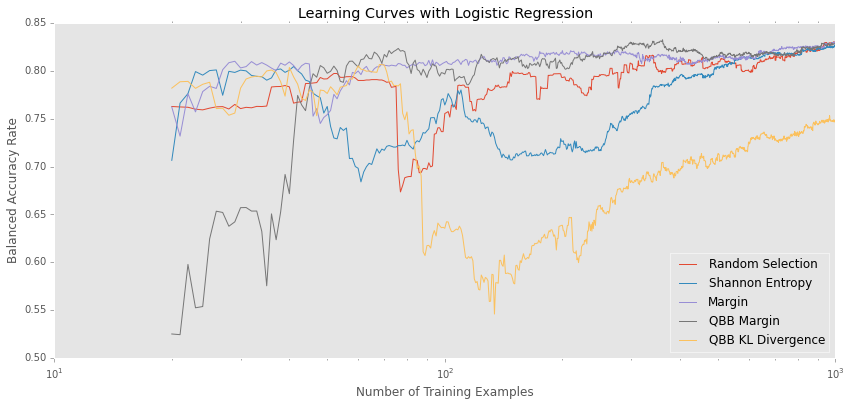

In [231]:
with open('results/sdss_active_learning/lc_logistic.pickle', 'rb') as f:
    lc_logistic_random, lc_logistic_entropy, lc_logistic_margin, \
    lc_logistic_qbb_margin, lc_logistic_qbb_kl = pickle.load(f)

fig1 = plt.figure(figsize=(14, 6))
ax1a = fig1.add_subplot(111)
ax1a.plot(n_examples, lc_logistic_random, label='Random Selection')
ax1a.plot(n_examples, lc_logistic_entropy, label='Shannon Entropy')
ax1a.plot(n_examples, lc_logistic_margin, label='Margin')
ax1a.plot(n_examples, lc_logistic_qbb_margin, label='QBB Margin')
ax1a.plot(n_examples, lc_logistic_qbb_kl, label='QBB KL Divergence')
ax1a.set_xlabel('Number of Training Examples')
ax1a.set_ylabel('Balanced Accuracy Rate')
ax1a.legend(loc='lower right')
ax1a.set_title('Learning Curves with Logistic Regression')
ax1a.tick_params(top='off', right='off')
ax1a.set_xscale('log')
ax1a.grid(False)
plt.show()

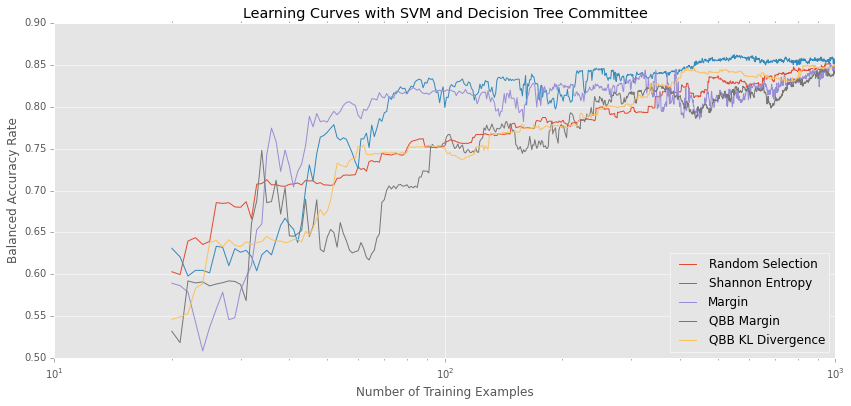

In [239]:
with open('results/sdss_active_learning/lc_svm.pickle', 'rb') as f:
    lc_svm_random, lc_svm_entropy, lc_svm_margin, \
    lc_svm_qbb_margin, lc_svm_qbb_kl = pickle.load(f)

fig2 = plt.figure(figsize=(14, 6))
ax2a = fig2.add_subplot(111)
ax2a.plot(n_examples, lc_svm_random, label='Random Selection')
ax2a.plot(n_examples, lc_svm_entropy, label='Shannon Entropy')
ax2a.plot(n_examples, lc_svm_margin, label='Margin')
ax2a.plot(n_examples, lc_svm_qbb_margin, label='QBB Margin')
ax2a.plot(n_examples, lc_svm_qbb_kl, label='QBB KL Divergence')
ax2a.set_xlabel('Number of Training Examples')
ax2a.set_ylabel('Balanced Accuracy Rate')
ax2a.legend(loc='lower right')
ax2a.set_title('Learning Curves with SVM and Decision Tree Committee')
ax2a.tick_params(top='off', right='off')
ax2a.set_xscale('log')
plt.show()